# Train a single-task regression model from scratch

In [1]:
import os
import numpy as np
import pandas as pd
import torch

## Set experiment parameters

In [2]:
experiment='tutorial_3'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Peak and fragment files

We downloaded pseudobulk scATAC data for human microglia from Corces et al. (2020): `https://www.nature.com/articles/s41588-020-00721-x`. Here, we use the `grelu.resources` module to download the fragment file and peak file from the model zoo:

In [3]:
# Load dataset to train the model
import grelu.resources

fragment_file_dir = grelu.resources.get_artifact(project='microglia-scatac-tutorial', name='fragment_file').download()
peak_file_dir = grelu.resources.get_artifact(project='microglia-scatac-tutorial', name='peak_file').download()

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: lal-avantika (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact fragment_file:latest, 2203.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.7
wandb:   1 of 1 files downloaded.  


In [4]:
# Paths to files
frag_file = os.path.join(fragment_file_dir, "Microglia_full.bed")
peak_file = os.path.join(peak_file_dir, "Microglia_full_peaks.narrowPeak")

## Set parameters

In [5]:
seq_len=2114
label_len=1000
val_chroms=["chr10"]
test_chroms=["chr11"]
genome="hg38"

## Read peak file

In [6]:
import grelu.io.bed
peaks = grelu.io.bed.read_bed(peak_file)
peaks.tail(3)

,chrom,start,end,3,4,5,6,7,8,9
83317,chrY,56870777,56870983,Microglia_full_peak_83318,94,.,3.83352,11.58170,9.41381,116
83318,chrY,56873629,56873811,Microglia_full_peak_83319,49,.,3.01171,7.02098,4.99754,105
83319,chrY,56874075,56874225,Microglia_full_peak_83320,42,.,2.86533,6.19767,4.20704,17


## Summit-center peaks

In [7]:
import grelu.data.preprocess
peaks = grelu.data.preprocess.extend_from_summit(peaks, seq_len=seq_len)
peaks.tail(3)

,chrom,start,end
83317,chrY,56869836,56871950
83318,chrY,56872677,56874791
83319,chrY,56873035,56875149


## Filter peaks

In [8]:
# Filter peaks outside autosomes
peaks = grelu.data.preprocess.filter_chromosomes(peaks, 'autosomes')

Keeping 80823 intervals


In [9]:
# Filter peaks close to blacklist regions
peaks = grelu.data.preprocess.filter_blacklist(peaks, genome=genome, window=50)

Keeping 80823 intervals


## Get GC matched negative regions

In [10]:
negatives = grelu.data.preprocess.get_gc_matched_intervals(
    peaks,
    binwidth=0.02, # resolution of measuring GC content
    genome=genome,
    chroms="autosomes", # negative regions will also be chosen from autosomes
    #gc_bw_file='gc_hg38_2114.bw',
    blacklist=genome, # negative regions overlapping blacklist will be dropped
)
negatives.head(3)

Extracting matching intervals


100%|███████████████████████████████████████████████████████████████████████████| 80823/80823 [00:11<00:00, 6936.42it/s]


GC paired t-test: 0.0274, 8.42e-27
Filtering blacklist
Keeping 78343 intervals


,chrom,start,end
0,chr7,18637503,18639617
1,chr1,3162382,3164496
2,chr1,3376140,3378254


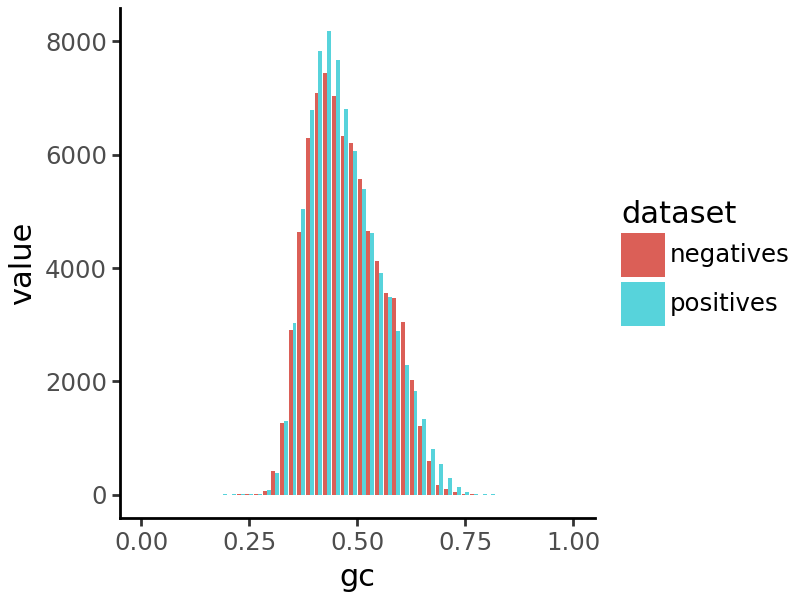

In [11]:
import grelu.visualize
grelu.visualize.plot_gc_match(positives=peaks, negatives=negatives, binwidth=0.02, genome="hg38")

## Combine peaks and negative regions

In [12]:
regions = pd.concat([peaks, negatives])

## Make BigWig file

We convert the ATAC-seq fragment file into a bigWig file which contains the number of Tn5 insertions at each position.

In [ ]:
bw_file = grelu.data.preprocess.make_insertion_bigwig(
    frag_file = frag_file,
    plus_shift=0, minus_shift=1,
    genome=genome,
    chroms="autosomes",
)

Making bedgraph file
cat /code/grelu/docs/tutorials/artifacts/fragment_file:v1/Microglia_full.bed | awk -v OFS="\t" '{print $1,$2+0,$3,1000,0,"+";
    print $1,$2,$3+1,1000,0,"-"}' | sort -k1,1 | grep -e ^chr1 -e ^chr2 -e ^chr3 -e ^chr4 -e ^chr5 -e ^chr6 -e ^chr7 -e ^chr8 -e ^chr9 -e ^chr10 -e ^chr11 -e ^chr12 -e ^chr13 -e ^chr14 -e ^chr15 -e ^chr16 -e ^chr17 -e ^chr18 -e ^chr19 -e ^chr20 -e ^chr21 -e ^chr22  | bedtools genomecov -bg -5 -i stdin -g /root/.local/share/genomes/hg38/hg38.fa.sizes | bedtools sort -i stdin > ./Microglia_full.bedGraph


## Split data by chromosome

In [ ]:
train, val, test = grelu.data.preprocess.split(
    regions, val_chroms=val_chroms, test_chroms=test_chroms)

## Make labeled datasets

In [ ]:
import grelu.data.dataset

train_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = train,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    rc=True, # reverse complement
    max_seq_shift=3, # Shift the sequence
    max_pair_shift=50, # Shift both sequence and label
    augment_mode="random",
    seed=0,
)
val_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = val,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum", 
    max_seq_shift=3,
    max_pair_shift=50,
    augment_mode="random",
    seed=0,
)

# No augmentation in the test set
test_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = test,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    augment_mode="serial",
    seed=0,
)

len(train_ds), len(val_ds), len(test_ds)

## Build model

In [ ]:
model_params = {
    'model_type':'DilatedConvModel',
    'crop_len':(seq_len-label_len)//2,
    'n_tasks':1,
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression',
    'loss': 'poisson',
    'logger':'csv',
    'lr':1e-4,
    'batch_size':512,
    'max_epochs':10,
    'devices':1,
    'num_workers':16,
    'save_dir':experiment,
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

## Train model

In [ ]:
trainer = model.train_on_dataset(train_ds, val_ds)

## Load the best model

In [ ]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)

In [ ]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Evaluate model

In [ ]:
test_metrics = model.test_on_dataset(test_ds, batch_size=512, devices=0, num_workers=8)
test_metrics

## Run inference on held out sequences

In [ ]:
preds = model.predict_on_dataset(
    test_ds, devices=0, num_workers=8
    )
preds.shape

In [ ]:
grelu.visualize.plot_pred_scatter(
    preds=preds, labels=test_ds.get_labels(), density=True
)

## Run modisco

We now run TF-Modisco on the test set peaks. TF-modisco identifies motifs that consistently contribute to the model's output. Since we are using the microglia filter to limit the model's prediction to microglia, we will only get motifs relevant to this cell type. We also use TOMTOM to match the Modisco motifs to a set of reference motifs. Here, we use a reference set of non-redundant motifs (https://www.vierstra.org/resources/motif_clustering) that are provided with gReLU as `consensus`.

In [ ]:
import grelu.interpret.score

grelu.interpret.score.run_modisco(
    model,
    seqs=test.iloc[:2000, :],
    genome="hg38",
    method="ism",
    meme_file="consensus",
    out_dir=experiment,
    devices=0,
    window=400,
    batch_size=512,
    num_workers=16,
)

## Extract TOMTOM matches from modisco

The full output of TF-Modisco can be found in the experiment folder. Here, we list the significant TOMTOM matches, i.e. known TF motifs that are similar to those found by TF-MoDISco.

In [ ]:
tomtom_dir = os.path.join(experiment, 'tomtom')
tomtom = grelu.io.read_tomtom(tomtom_dir, qthresh=.01)
tomtom.head()

In [ ]:
tomtom.groupby('Query_ID').Target_ID.agg(list)

## Perform a marginalization experiment

To understand the effect of the `AC0622:ELF_SPIB:Ets` motif, we perform a marginalization experiment. Here, we take the `AC0622:ELF_SPIB:Ets` motif and insert it into shuffled background sequences, and compare the predictions of the model before and after inserting this motif.

First, we read this motif from the MEME file and extract the consensus sequence.

In [ ]:
import grelu.io.meme
import grelu.interpret.motifs

motifs, _ = grelu.io.meme.read_meme_file("consensus", names=["AC0622:ELF_SPIB:Ets"])
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)

print(patterns)

We will select some peaks from the test set to shuffle and use as the background.

In [ ]:
result = grelu.interpret.motifs.marginalize_patterns(
    model=model,
    patterns=patterns,
    seqs = test.head(100),
    genome = "hg38",
    devices = 0,
    num_workers = 8,
    batch_size = 512,
    n_shuffles = 1, # Each peak will be shuffled 1 time, conserving dinucleotide frequency
    seed = 0,
    compare_func = "subtract", # Return the change in the prediction after inserting the pattern
)

In [ ]:
result.squeeze().mean()

We see that on average, inserting this motif into a shuffled peak sequence increases the model's prediction.